# Sentiment Trader
James Chan 2018

### Overview
A popular approach traders take to beat the stock market is by analyzing the market sentiment.  This is common done by analzying stock market news pertaining to a particular stock, a certain the sector, or even the world economy as a whole.  

##### Examples
* News headlined "Elon Musk pushed off Model 3 production once again!!!" could mean a sell/short opportunity for Tesla.
* News headlined "Pfizer found definitive cure for cancer!" could mean a long opporutnity for Pfizer, for the pharmaceutical sector, or even the world economy altogether.

### Machine Learning and NLP
Machine Learning is rapidly gaining grounds in quantitative finance due to its phenomonenal performance in forecasting, optimization, and decision-making. By combining the predictive power of machine learning with the processing of textual data in news, a intelligent agent may be devised which can translate news into trades with remarkable performance.

In this exercise we employ the following steps to construct a sentiment trader agent to trade Tesla.  More details of these steps are discussed later.
1. Acquire historical news and stock market performance of Tesla from the web
2. Clean the news and translate text into one hot vectors using NLP techniques
3. Train a logistics regression classifer using the return of next day as label
4. Assess the performance of the trader in-sample and out-of-sample

In [1]:
'''
Sentiment Trader
James Chan 2018
'''
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import st_utils as sut
import trader_utils as tut
import string

from scipy.stats import mode

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from dateutil import parser
from datetime import timedelta, date

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
# initialize date range of interest.  Longer would be even better, but I would need to sign up for a paid plan at newsapi.org
start_date = '2018-01-01'
end_date = '2018-8-31'

In [114]:
# download news by querying newsapi.org
keywords = ['tesla'] #use tesla as keyword
news_source = 'wsj.com, bloomberg.com, cnbc.com' #use these 3 news outlet , more will be even better
df = sut.get_news(keywords, start_date, end_date, news_source)
df.to_csv('news_dataset.csv')

{'status': 'ok', 'totalResults': 1917, 'articles': []}
total number of articles  1917
downloading page:  1
downloading page:  2
downloading page:  3
downloading page:  4
downloading page:  5
downloading page:  6
downloading page:  7
downloading page:  8
downloading page:  9
downloading page:  10
downloading page:  11
downloading page:  12
downloading page:  13
downloading page:  14
downloading page:  15
downloading page:  16
downloading page:  17
downloading page:  18
downloading page:  19
downloading page:  20
download complete


In [115]:
df_news = pd.read_csv('news_dataset.csv', index_col=0, encoding="ISO-8859-1")
df_news.head()

,Published,Title,Body,Keyword,Source
0,2018-04-03T13:05:17Z,"Tesla Ends 1Q Making 2,020 Model 3 Sedans per ...","Tesla 1Q deliveries totaled 29,980 vehicles, B...",tesla,Bloomberg
1,2018-07-24T07:48:09Z,Tesla Wants Its Money Back,Elon Musk is asking for donations to save Tesl...,tesla,The Wall Street Journal
2,2018-07-01T22:13:00Z,What Tesla can do to keep the bears at bay dur...,"Buckle up, because Tesla could be in for a bum...",tesla,CNBC
3,2018-05-09T15:00:00Z,Two Florida teenagers killed in Tesla crash,Tesla said it is cooperating with authorities ...,tesla,CNBC
4,2018-05-10T19:00:00Z,NHTSA joins NTSB in looking into fatal Tesla c...,Tesla said it is cooperating with authorities ...,tesla,CNBC


The news is now in the form of a dataframe.  Further processing will be needed before it can be fed into our agent.  But before we do that, let's get the daily return first so we will all the raw data necessary for this exercise

In [109]:
# get Tesla's prices
dates = pd.date_range(start_date, end_date)
file = 'TSLA.csv'
df_stock = sut.get_data(file, dates)

In [110]:
# calculate return 
df_stock['Return'] = df_stock['Adj Close'].shift(-1)/df_stock['Adj Close'].values-1.0
df_stock.drop(df_stock.index[-1], inplace=True)

In [112]:
df_stock.head()

,Adj Close,Return
2018-01-02,320.529999,-0.010233
2018-01-03,317.250000,-0.008290
2018-01-04,314.619995,0.006230
2018-01-05,316.579987,0.062638
2018-01-08,336.410004,-0.008085


Now that we have both the news and the daily return, it's time to define the framing of the problem.

### Framing the Problem
In the real world, speed plays a huge factor in the success of a trading firm.  Ideally bots are used to monitor news channels real-time so they can quickly grab news releases and feed them into the trading system pipeline.  This simply cannot be achieved reliably using  in this exercises, so we are going to make some assumptions and simplifications about the stock market.  


In [7]:
# map published time to close date.  see figure.1
def map_to_close_date(published_date):
    dt = parser.parse(published_date[:-1]) #-1 to ignore the Z, which is GMT.
    dt = dt - timedelta(hours=20) #shift back by 20 hrs.
    return pd.Timestamp(year=dt.year, month=dt.month, day=dt.day)

In [8]:
# map news to close date
df_news['Published'] = df_news['Published'].apply(map_to_close_date)

In [9]:
# combine title and body into single text
df_news['Text'] = df_news['Title'] + ' ' + df_news['Body']

In [10]:
# just keep published, and the combined text
df_news = df_news[['Published','Text']]

In [11]:
# merge news and stock
df_stock['Published'] = df_stock.index
df_merged = pd.merge(df_news, df_stock, how='left', on='Published')
df_merged = df_merged.dropna()
df_merged = df_merged.sort_values(by='Published')
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,Stock Fund That Beats 95% of Peers Ignores CEO...,320.529999,-0.010233
1733,2018-01-02,Five Things You Need to Know to Start Your Day...,320.529999,-0.010233
1718,2018-01-02,Car Sales to Top 90 Million Globally for First...,320.529999,-0.010233
409,2018-01-02,"With one simple tweet, Elon Musk shows a maste...",320.529999,-0.010233
1398,2018-01-02,Electric Car Drivers Are Too Smart to Own Elec...,320.529999,-0.010233


In [12]:
def tokenize_news(text):
    if(type(text)==float):
        return []
    lmtzr = WordNetLemmatizer()
    stmr = PorterStemmer()
    translator = str.maketrans('', '', string.punctuation)
    text = (text.translate(translator))
    text = "".join(c for c in text if ord(c)<128) #strip no n ascii characters
    tokens = word_tokenize(text)
    t = []
    minlen =  4
    maxlen = 20 
    for token in tokens:
        if len(token) < minlen or len(token) > maxlen or token.isnumeric() or token in stopwords.words('english'):
            pass
        else:
            token = lmtzr.lemmatize(token)
            token = stmr.stem(token)
            t.append(token)
    return t

In [13]:
df_merged['Text'] = df_merged['Text'].apply(tokenize_news)

In [14]:
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,"[stock, fund, that, beat, peer, ignor, talk, r...",320.529999,-0.010233
1733,2018-01-02,"[five, thing, need, know, start, your, caught,...",320.529999,-0.010233
1718,2018-01-02,"[sale, million, global, first, time, global, s...",320.529999,-0.010233
409,2018-01-02,"[with, simpl, tweet, elon, musk, show, master,...",320.529999,-0.010233
1398,2018-01-02,"[electr, driver, smart, electr, car, almost, p...",320.529999,-0.010233


In [16]:
#construct vocabulary and frequency.  frequency is not really needed, just nice to have for understanding the concept.
vocab = {}
frequency = {}
ignore = ['bloomberg', 'journal']
index = 0
for title in df_merged['Text']:
    for word in title:
        if word in ignore:
            continue
        if word not in vocab:
            
            vocab[word] = index
            index += 1
            frequency[word] = 1
        else:
            frequency[word] += 1

In [17]:
#visualize words frequency
for i, freq in enumerate(sorted(frequency.items(), key=lambda x:x[1], reverse=True)):
    if i == 10:
        break
    print(freq)

('tesla', 1094)
('musk', 458)
('elon', 364)
('compani', 254)
('stock', 248)
('model', 240)
('say', 180)
('china', 160)
('share', 159)
('electr', 159)


In [18]:
vocab_len = len(vocab)

In [89]:
df_merged['Published'][df_merged['Published'] == pd.datetime(2018,5,1)]

1741   2018-05-01
375    2018-05-01
1601   2018-05-01
1001   2018-05-01
163    2018-05-01
1198   2018-05-01
690    2018-05-01
389    2018-05-01
1209   2018-05-01
387    2018-05-01
1172   2018-05-01
329    2018-05-01
420    2018-05-01
1418   2018-05-01
124    2018-05-01
Name: Published, dtype: datetime64[ns]

In [90]:
in_sd = df_merged['Published'].iloc[0]
in_ed = pd.datetime(2018,4,30)
out_sd = pd.datetime(2018,5,1)
out_ed = df_merged['Published'].iloc[-1]

df_training_data = df_merged[np.logical_and(df_merged['Published'] >= in_sd, df_merged['Published'] <= in_ed)]
df_testing_data = df_merged[np.logical_and(df_merged['Published'] >= out_sd, df_merged['Published'] <= out_ed)]

In [91]:
def to_one_hot(text):
    #return one hot vector of shape (vocab_len, 1)
    array = np.zeros((vocab_len, 1))
    for word in text:
        if word in vocab:
            index = vocab[word]
            array[index] = 1
    return array

In [92]:
def get_X(df_text):
    X = np.empty((vocab_len,0))
    for text in df_text:
        array = to_one_hot(text)
        X = np.hstack((X,array))
    X = X.T
    return X

In [93]:
# here is the exciting part. here we are going to create the training data!
train_x = get_X(df_training_data['Text'])
test_x = get_X(df_testing_data['Text'])

In [94]:
# get labels
train_y = df_training_data['Return'].values.copy()
test_y = df_testing_data['Return'].values.copy()

In [95]:
train_y[train_y <= 0] = 0
train_y[train_y > 0] = 1

test_y[test_y <= 0] = 0
test_y[test_y > 0] = 1

In [96]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(675, 4528)
(675,)
(554, 4528)
(554,)


In [98]:
#train the model
model = Sequential()
model.add(Dense(1, input_dim=train_x.shape[1], activation='relu', kernel_initializer='uniform'))
# model.add(Dense(12, activation='relu', kernel_initializer='uniform'))
# model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)

In [99]:
#view weights
weights, biases = model.layers[0].get_weights()
for i, k in enumerate(vocab.keys()):
    if i == 10:
        break
    print(k, weights[i])

stock [0.06316894]
fund [0.02996688]
that [0.00551409]
beat [0.00839819]
peer [-0.00527481]
ignor [-0.17625849]
talk [0.008567]
research [0.05196967]
read [0.00197813]
brokerag [-0.22932746]


In [100]:
#assess in-sample accuracy
predictions = model.predict_classes(train_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == train_y) / train_y.shape[0]

0.9451851851851852

In [101]:
#assess out-of-sample accuracy
predictions = model.predict_classes(test_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == test_y) / test_y.shape[0]

0.4981949458483754

In [102]:
#generate trades
def generate_trades(df, ticker):
    sd = df['Published'].iloc[0]
    ed = df['Published'].iloc[-1]
    trades = tut.get_prices(ticker, sd, ed)
    trades[:] = 0
    curr_date = sd
    votes = []
    for date, text in zip(df['Published'], df['Text']):
        if date != curr_date:
            trades.loc[curr_date] = mode(votes)[0][0]
            votes = []
            curr_date = date
        text_vector = to_one_hot(text)
        prediction = model.predict_classes(text_vector.T)
        votes.append(prediction[0][0])
    trades = tut.predictions_to_trades(ticker, trades.values, sd, ed, 1, 0)
    return trades

In [103]:
in_trades = generate_trades(df_training_data, 'TSLA')

In [104]:
starting_cash = 100000
holding_limit = 1000
btr = tut.BackTester(starting_cash, holding_limit)

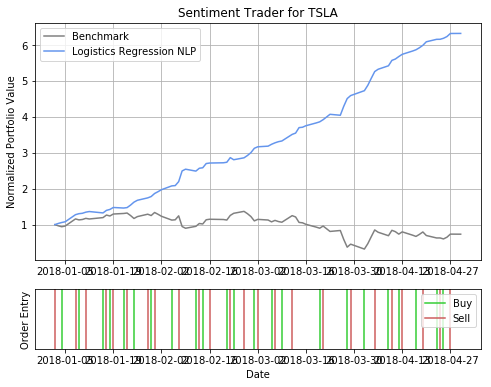

In [105]:
btr.backtest(in_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')

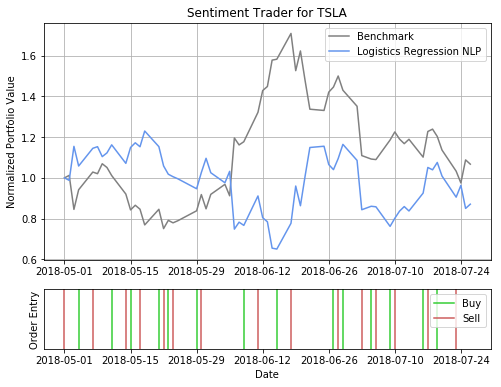

In [106]:
out_trades = generate_trades(df_testing_data, 'TSLA')
btr.backtest(out_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')